In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
from http.client import IncompleteRead

In [2]:
data = pd.read_csv('results/focus.csv', index_col=0)
df = data.head(5)

In [3]:
top_companies = []
for i, row in df.iterrows():
    print(i)
    top_companies.append(i)

ADMCM.HE
ICP1V.HE
VIAFIN.HE
NESTE.HE
GOFORE.HE


In [4]:
def price_history(company, timeline):
    max_try = 5
    attemp = 1
    while attemp < max_try:
        try:
            yf = YahooFinancials(company)
            data = yf.get_historical_price_data('2020-04-12', '2021-04-12', timeline)
            data_1 = data[company]['prices']

        except IncompleteRead:
            attemp += 1
            if attemp == max_try:
                print(f'Failed {N}')
        except ValueError as e:
            print(f'{e}: {N}')
            attemp = max_try
        else:
            break
            
    df = pd.DataFrame.from_dict(data_1)
    if timeline == 'weekly':
        df.to_csv(f"results/price_history_weekly_{company.split('.')[0]}.csv")
    elif timeline == 'monthly':
        df.to_csv(f"results/price_history_monthly_{company.split('.')[0]}.csv")
    else:
        df.to_csv(f"results/price_history_{company.split('.')[0]}.csv")

In [5]:
top_prices = []

for i in top_companies:
    price_history(i, 'daily')    
    top_prices.append(f"results/price_history_{i.split('.')[0]}.csv")
    print(f"results/price_history_{i.split('.')[0]}.csv")

results/price_history_ADMCM.csv
results/price_history_ICP1V.csv
results/price_history_VIAFIN.csv
results/price_history_NESTE.csv
results/price_history_GOFORE.csv


In [6]:
df_data = []
for i in top_prices:
    data = pd.read_csv(i, index_col='formatted_date', parse_dates=True)
    del data['Unnamed: 0']
    df_data.append(data)

In [17]:
# 15 days average same calculation than below
# df[0]['close'].iloc[:15].mean()

df_list = []
for n in range(len(top_prices)):
    df = df_data[n].copy()
#     df['SMA'] = df['close'].rolling(30).mean()
    df['SMA'] = df['close'].ewm(span=50, adjust=False).mean()

    df = df[['close', 'SMA']]
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df['dif'] = df['close'] - df['SMA']
    df_list.append(df)

In [18]:
df_list[0]

,formatted_date,close,SMA,dif
0,2020-04-14,71.800003,71.800003,0.000000
1,2020-04-15,68.000000,71.650983,-3.650983
2,2020-04-16,67.000000,71.468592,-4.468592
3,2020-04-17,67.000000,71.293353,-4.293353
4,2020-04-20,67.400002,71.140672,-3.740671
...,...,...,...,...
244,2021-04-01,97.000000,102.468142,-5.468142
245,2021-04-06,95.400002,102.190960,-6.790959
246,2021-04-07,98.000000,102.026609,-4.026609
247,2021-04-08,97.199997,101.837330,-4.637333


In [19]:
for n in range(len(df_list)):
    dif_list = df_list[n]['dif'].tolist()
    buy = {}
    sell = {}
    pos = None
    profit = 0

    for i in range(len(dif_list)):
        current = dif_list[i]
        past =  dif_list[i - 1]

        current_price = df.iloc[i]['close']

        if current < 0 and past > 0:
            sell.update({i: current_price})
            pos = 'Sell' 
            if len(buy) > 0:
                last_buy = buy[max(buy.keys())]

#                 print(f'Entering Price: {last_buy}')
#                 print(f'Exit Price: {current_price}')
#                 print(f'Position: Buy')
#                 print(f'Profit: {current_price - last_buy}\n')

                profit += current_price - last_buy

        elif current > 0 and past < 0:
            buy.update({i: current_price})
            pos = 'Buy'

            if len(sell) > 0:
                last_sell = sell[max(sell.keys())]

#                 print(f'Entering Price: {last_sell}')
#                 print(f'Exit Price: {current_price}')
#                 print(f'Position: Sell')
#                 print(f'Profit: {last_sell - current_price}\n')

                profit += last_sell - current_price

        if i == len(dif_list) - 1:
            if pos == 'Buy':
                sell.update({i: current_price})
                last_buy = buy[max(buy.keys())]

#                 print(f'Entering Price: {last_buy}')
#                 print(f'Exit Price: {current_price}')
#                 print(f'Position: Buy')
#                 print(f'Profit: {current_price - last_buy}\n')

                profit += current_price - last_buy
            else:
                buy.update({i: current_price})
                last_sell = sell[max(sell.keys())]

#                 print(f'Entering Price: {last_sell}')
#                 print(f'Exit Price: {current_price}')
#                 print(f'Position: Sell')
#                 print(f'Profit: {last_sell - current_price}\n')

                profit += last_sell - current_price    
    
    print(f"{top_companies[n]} Original Profit: {df_list[n].iloc[-1]['close'] - df_list[n].iloc[0]['close']}")
    print(f"{top_companies[n]} Method Profit: {profit}\n")

ADMCM.HE Original Profit: 25.89999389648439
ADMCM.HE Method Profit: 1.9600009918212935

ICP1V.HE Original Profit: 14.361414909362793
ICP1V.HE Method Profit: 15.880000114440922

VIAFIN.HE Original Profit: 7.550000190734863
VIAFIN.HE Method Profit: 4.580002784728997

NESTE.HE Original Profit: 15.600000381469727
NESTE.HE Method Profit: 8.439996242523197

GOFORE.HE Original Profit: 14.260000228881836
GOFORE.HE Method Profit: 13.479999542236321



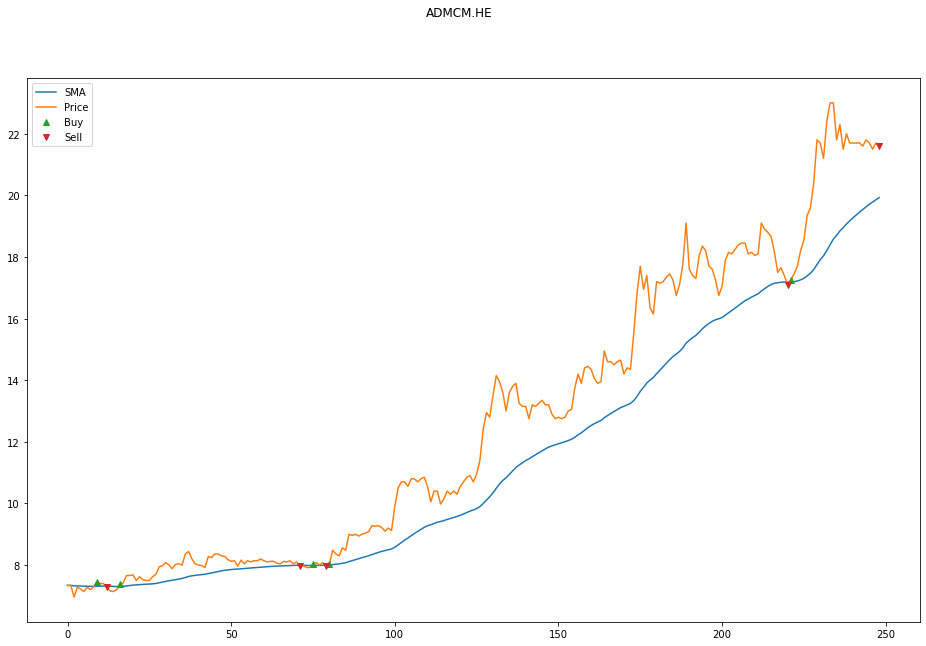

In [21]:
plt.figure(figsize=(16,10))
plt.suptitle(top_companies[0])
plt.plot(df['SMA'], label='SMA')
plt.plot(df['close'], label='Price')
plt.plot(list(buy.keys()), list(buy.values()), '^', label='Buy')
plt.plot(list(sell.keys()), list(sell.values()), 'v', label='Sell')
plt.legend(loc='best')
plt.show()